<h1>Energy-Specific study of the performance of Neural Network Analysis.</h1>

Let us scale down the NN analysis on the fluence spectra and focus on a few (initially one) characteristic energy of nuclear residue radiation.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 14
np.random.seed(2024061)

import import_ipynb
from NuclearAssemblies import *

import pandas as pd

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
importing Jupyter notebook from NuclearAssemblies.ipynb


<h2>Reading the data</h2>

We import the data generated by the ```DataGen_ESS``` notebook.

In [2]:
df=pd.read_pickle('pickle/FluDat_ESS7.pickle')
df.head()

,AssemblyPinslots,SpectraCylinder
0,"[[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1],...","[[1.2698557], [1.3029325], [1.4130867], [1.641..."
1,"[[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1],...","[[1.2698557], [1.3029325], [1.4130867], [1.641..."
2,"[[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1],...","[[1.2698557], [1.3029325], [1.4130867], [1.641..."
3,"[[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1],...","[[1.2698557], [1.3029325], [1.4130867], [1.641..."
4,"[[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1],...","[[1.2698557], [1.3029325], [1.4130867], [1.641..."


<h2>Statistical study</h2>

This corresponds to pages 7 and 8 of the hand notes.

Let us begin with classical analysis techniques. We are going to plot the number of present pins in the assembly against the measured fluence averaged over all the angles for a specific energy (in our case 99 keV as justified above). That is the dependence we wish to characterise. Notice that we have obtained the data the other way around: from the present pins (and their locations) we computed the fluences.

We firstly simply plot the data.

In [3]:
Y=np.array(df['AssemblyPinslots'].tolist())
X=np.array(df['SpectraCylinder'].tolist())
y=np.array([np.sum(ass) for ass in Y])
x=np.array([np.sum(ass)/len(ass) for ass in X])

In [4]:
len(y)/np.max(y)

200.0

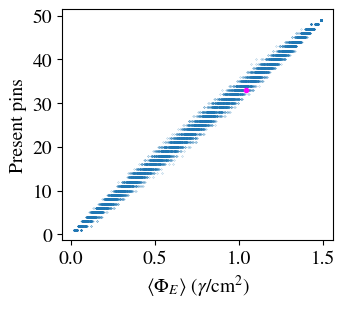

In [5]:
fig=plt.figure(figsize=(3.5,3))
plt.scatter(x,y,s=0.1,marker='.')
plt.scatter(x[3252],y[3252],marker='.', color='magenta') 
        # An arbitrary point to follow transformations more easily
plt.ylabel('Present pins')
plt.xlabel('$\langle\Phi_E\\rangle$ ($\gamma/$cm$^2$)') # Double \\ before rangle to avoid py interpreting \r
plt.yticks([0,10,20,30,40,50])
plt.savefig('./Graphs/ESS/Classic_leaf_magenta.pdf',bbox_inches='tight')
plt.show()

We wish to infer information from the above graphic. We can see that it is leaf-shaped so from now on we will call it _the leaf_. Our objective is to find a way to, given a set fluence, return a confidence interval of the amount of pins present in the assembly.

Let us begin with the numerical study of the leaf. Note that, for completion, we are missing the 0 pins measurements, for which the fluence will undeniably be 0. This will have to be taken into account in the analysis.

Firstly we want to center the leaf, and not necessarily the data, at (0,0). In this case they don't coincide due to the lack of data corresponding to 0 pins. Secondly, we will rescale the axis to make them numerically comparable, which can be done by dividing the dependent variable, or multiplying the independent variable, by the slope. We are going to do the latter to avoid having to work with such small numbers.

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
reg=LinearRegression(fit_intercept=False).fit(x[:,np.newaxis],y)
    # We force the fit to pass through 0 (if there are 0 pins, the fluence will undeniably be 0)

    # The centre of the leaf
yc=np.max(y)/2
xc=yc/reg.coef_[0]
    
    # The centre is placed at (0,0) and the x axis rescaled
xcs=(x-xc)*reg.coef_[0] # Centered and Scaled
ycs=y-yc

print('Data centered and scaled. Fit slope: ',reg.coef_[0])

Data centered and scaled. Fit slope:  32.88129574215091


This way, our new variables are related with a slope of 1. Therefore to rotate them we only need to multiply by the $45^\circ$ clockwise rotation matrix, which is

$${\frac{1}{\sqrt{2}}}\begin{pmatrix}1&1\\-1&1\end{pmatrix}$$

but as we stated on page 8 of the hand notes, we don't really mind about rescaling when rotating, so we can ignore the $\frac{1}{\sqrt{2}}$ factor.

In [8]:
M=np.array([[1,1],[-1,1]])
p=np.array([xcs,ycs]) # all data as column vectors
P=M@p

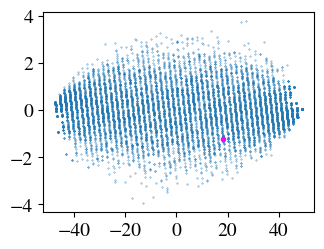

In [9]:
fig=plt.figure(figsize=(3.5,2.6))
plt.scatter(P[0],P[1],s=0.3,marker='.')
#plt.scatter(0,0,marker='.', color='red')
plt.scatter(P[0][3252],P[1][3252],marker='.', color='magenta')
plt.xticks([-40,-20,0,20,40])
plt.savefig('./Graphs/ESS/Classic_leaf_transformed.pdf',bbox_inches='tight')
plt.show()

<h3>Different fits</h3>

We can see above the leaf shape of the data. Looking at the non-rotated data one can hypothesise that a good empirical fit would be a pair of parabolas, or an ellipse. Notice that the parabolas could stablish the relationship within the rotated, or withing the unrotated, coordinates. We are going to work only with the former.

First of all, note that all fitting curves will have to cross the x-axis at exactly two points, which are easily found as `-2*yc` and `2*yc` (see below `xrot`), assuming symetry in the line of best fist with respect to the middle point (this is a reasonable assumption due to combinatorics arguments and the way we have defined the rotation transformation).

<h4>Double parabolas</h4>

In [10]:
def accuracy_parabolas(ld_coef,xrot,P,offset=0.05,draw=True):
    # This function returns the percentage of dots contained within the two parabolas given by
    # y=±ld_coef(x+xrot)(x-xrot)
    
    if ld_coef<=0: raise Exception('Leading coefficient must be greater than 0.')
    if xrot<=0: raise Exception('xrot must be greater than 0.')
    if offset<0: raise Exception('offset must be greater than or equal to 0.')
    
    def top_par(var):
        return -1*ld_coef*(var+xrot)*(var-xrot)+offset
    def bot_par(var):
        return ld_coef*(var+xrot)*(var-xrot)-offset
    
    if draw:
        plt.scatter(P[0],P[1],s=0.3,marker='.')
        plt.scatter(0,0,marker='.', color='red')
        plt.scatter(P[0][3252],P[1][3252],marker='.', color='magenta')
        pts=np.linspace(-xrot,xrot,100)
        plt.plot(pts,top_par(pts),color='orange',linewidth=0.4)
        plt.plot(pts,bot_par(pts),color='orange',linewidth=0.4)
        plt.show()
    
    return sum(np.sign(top_par(P[0])-P[1])==np.sign(P[1]-bot_par(P[0])))/len(P[0])

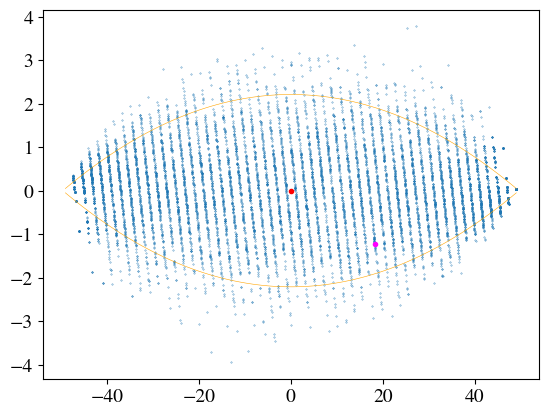

Acurracy with ld_coef = 0.0009 is 84.1734693877551 %.


In [11]:
ld_coef=0.0009
xrot=(M@np.array([yc,yc]))[0] # xavg*reg.coef_[0]=yavg

print('Acurracy with ld_coef =',ld_coef,'is',accuracy_parabolas(ld_coef,xrot,P)*100,'%.')

It appears that the parabolas leave a proportionally high amount of data entries of the extrema unaccounted for. We can easily check this by feeding the function only the assemblies corresponding to a fixed number of pins (which is easy thanks to not having shuffled the data).

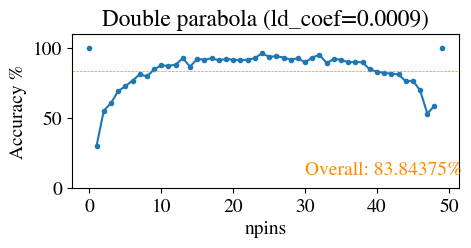

In [12]:
lAss_pin=int(len(y)/np.max(y))

acc=100

for npins in np.unique(y):
    newacc=accuracy_parabolas(ld_coef,xrot,P[:,(np.max(y)-npins)*lAss_pin:(np.max(y)-npins+1)*lAss_pin],draw=False)
    acc=np.append(acc,newacc*100)
    
ovacc=accuracy_parabolas(ld_coef,xrot,P[:,lAss_pin:],draw=False)*100 
        # We remove the assemblies corresponding to full pin capacity (100% accuracy) to avoid bias in the mean.

fig=plt.figure(figsize=(5,2))
plt.axhline(y=ovacc,xmin=0,xmax=np.max(y),color='darkorange',linestyle='--',linewidth=0.5)
plt.scatter(np.append(0,np.unique(y)),acc,marker='.')
plt.plot(np.unique(y)[:-1],acc[1:-1])
plt.title('Double parabola (ld_coef='+str(ld_coef)+')')
plt.ylim((0,110))
plt.xlabel('npins')
plt.ylabel('Accuracy %')
plt.text(30,10,'Overall: '+str(ovacc)+'%',color='darkorange')
plt.show()


We can see that for middle values of npins the accuracy is quite high compared to the overall accuracy, and that when we get to very few or many pins the accuracy greatly decreases, meaning that the double parabola method underestimates the error there. Ideally our fitting method would provide a constant accuracy with respect to the number of pins.

Note that trivially the accuracy for no pins will always be 100%, as the fluence will always be 0 (assuming no activated materials in the assembly structure), and that for our dataset the accuracy for all pins present will also be 100%. This will change when we generate the data randombly asigning different spectra to each present pin.

<h4>Ellipse</h4>

Now we are going to perform the same fit but with an ellipse. The curve equation of an ellipse is 

$$\frac{x^2}{a^2}+\frac{y^2}{b^2}=1$$

where $2a$ is the width and $2b$ the height. Thus we will keep $a=$ `xrot+offset` fixed and vary $b$ to modulate the accuracy. Hence the two curves will be given by

$$y_\pm=\pm\ b\sqrt{\left(1-\frac{x^2}{a^2}\right)}$$

*Note below that the offset is not necessary.*

In [13]:
def accuracy_ellipse(b,xrot,P,offset=0.01,draw=True):
    # This function returns the percentage of dots contained within the ellipse given by
    # y=±b*sqrt(1-x**2/a**2)
    
    if b<0: raise Exception('Leading coefficient must be greater than 0.')
    if xrot<=0: raise Exception('xcsavg must be greater than 0.')
    if offset<0: raise Exception('offset mustn\'t be smaller than 0.')
    a=xrot+offset
    
    def top_elli(var):
        return b*np.sqrt(1-var**2/a**2)
    def bot_elli(var):
        return -b*np.sqrt(1-var**2/a**2)
    
    if draw:
        fig=plt.figure(figsize=(3.5,2.45))
        plt.scatter(P[0],P[1],s=0.3,marker='.')
        #plt.scatter(0,0,marker='.', color='red')
        plt.scatter(P[0][3252],P[1][3252],marker='.', color='magenta')
        pts=np.linspace(-a,a,1000)
        plt.plot(pts,top_elli(pts),color='orange',linewidth=1)
        plt.plot(pts,bot_elli(pts),color='orange',linewidth=1)
        plt.text(27,-3.5,'b = %.1f'%(b))
        plt.xticks([-40,-20,0,20,40])
        plt.yticks([-4,-2,0,2,4])
        
        plt.savefig('./Graphs/ESS/Classic_leaf_ellipse.pdf',bbox_inches='tight')
        plt.show()
    
    return sum(np.sign(top_elli(P[0])-P[1])==np.sign(P[1]-bot_elli(P[0])))/len(P[0])

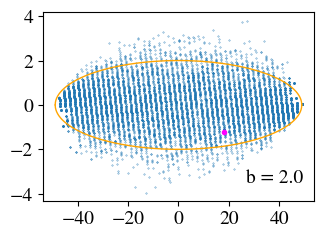

Acurracy with b = 2 is 91.5 %.


In [14]:
b=2
xrot=(M@np.array([yc,yc]))[0] # xavg*reg.coef_[0]=yavg
print('Acurracy with b =',b,'is',accuracy_ellipse(b,xrot,P)*100,'%.')

This already looks much better than the parabolas. Let us see how constant the accuracy is.

In [15]:
lAss_pin=int(len(y)/np.max(y))

b_=[0.5,1,1.5,2]
acc_=np.zeros((1,np.max(y)+1))
ovacc_=np.zeros(1)

for b in b_:
    acc=1 # We start with 100% accuracy for the empty assemblies
    for npins in np.unique(y):
        newacc=accuracy_ellipse(b,xrot,P[:,(np.max(y)-npins)*lAss_pin:(np.max(y)-npins+1)*lAss_pin],draw=False)
        acc=np.append(acc,newacc)
    ovacc=accuracy_ellipse(b,xrot,P[:,lAss_pin:],draw=False)
        # We remove the assemblies corresponding to full pin capacity (100% accuracy) to avoid bias in the mean.
    acc_=np.append(acc_,np.reshape(acc,(1,len(acc))),axis=0)
    ovacc_=np.append(ovacc_,ovacc)
acc_=np.delete(acc_,[0],axis=0)
ovacc_=np.delete(ovacc_,[0],axis=0)

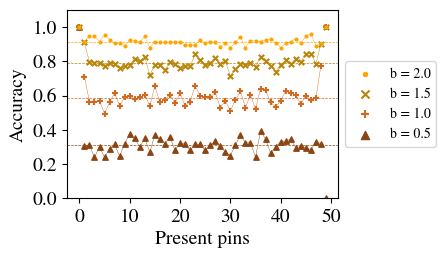

In [16]:
fig,ax=plt.subplots(figsize=(3.5,2.45))
marker_=['^','+','x','.']
colour_=['saddlebrown','chocolate','darkgoldenrod','orange']
for i in range(len(b_)):
    ax.axhline(y=ovacc_[i],xmin=0,xmax=np.max(y),linestyle='--',linewidth=0.5,color=colour_[i])
    ax.scatter(np.append(0,np.unique(y)),acc_[i],marker=marker_[i],color=colour_[i],s=15,label='b = %.1f'%(b_[i]))
    ax.plot(np.unique(y)[:-1],acc_[i][1:-1],color=colour_[i],linewidth=0.3)
ax.set_ylim((0,1.1))
ax.set_xlabel('Present pins')
ax.set_ylabel('Accuracy')
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_xticks([0,10,20,30,40,50])
plt.legend(reverse=True,loc='center left', bbox_to_anchor=(1, 0.5),markerscale=1.5,fontsize=10)
#plt.text(30,0.1,'Overall: '+str(ovacc)+'%',color='darkorange')
plt.savefig('./Graphs/ESS/Classic_leaf_ellipse_acc.pdf',bbox_inches='tight')
plt.show()

Thus we trivially conclude that the Ellipse is a more optimal description, and this result holds for other values of $b$.

From here we can programme a function that iteratively computes $b$ given a certain desired accuracy (confidence interval), to then undo the coordinate transformation. This way we could characterise the dependence of npins with respect to the read fluence. However, this would still be an interval. Let us see if the neural network can improve on the result (this ideally means giving a precise number with a high accuracy).

**Note:** If we want to compare results (NN vs ellipse) we will need to finish developing the algorithm that retrieves the interval from the fluence.

<h3>Using the ellipse to make predictions</h3>

Now we have seen that the ellipse is the best fit. Let us use it to predict the number of pins given the average fluence.

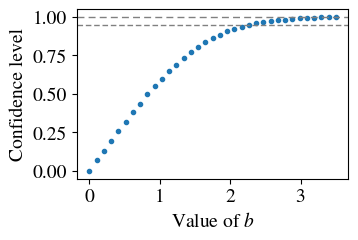

In [17]:
    # Let us get an idea of how the overall accuracy depends on parameter b

bvals=np.linspace(0,3.5,35)
acc=[]
for b in bvals:
        acc.append(accuracy_ellipse(b,xrot,P[:,lAss_pin:],draw=False))

fig=plt.figure(figsize=(3.5,2.2))
#plt.plot(bvals,acc)
plt.axhline(1,dashes=[5,3],linewidth=1,color='gray')
plt.axhline(0.95,dashes=[4,2],linewidth=1,color='gray')
plt.scatter(bvals,acc,marker='.')
#plt.title('Ellipse fitting')
plt.xlabel('Value of $b$')
plt.ylabel('Confidence level')
plt.yticks(np.arange(5)*0.25)
plt.savefig('./Graphs/ESS/b_interpol.pdf',bbox_inches='tight')
plt.show()

Once we have this result we can interpolate the value of $b$ that will grant us the accuracy we desire (confidence). That is, obtaining the inverse of the plotted curve.

In [18]:
conf=0.70
b_conf=np.interp(conf,acc,bvals)
print('Predicted b for',conf*100,'accuracy:',b_conf)
print('Actual accuracy:',accuracy_ellipse(b_conf,xrot,P[:,lAss_pin:],draw=False)*100)

Predicted b for 70.0 accuracy: 1.2580882352941176
Actual accuracy: 70.0625


And then we only need to undo the transformation on the coordinates in the ellipse equation and compute the function that relates `npins` to the fluence.

In [19]:
m=reg.coef_[0]
# We also use yavg

A=xrot**2+b_conf**2

def B(var):
    return 2*m*var*(b_conf**2-xrot**2)-4*yc*b_conf**2

def C(var):
    return m**2*var**2*A+4*yc*b_conf**2*(yc-m*var)-xrot**2*b_conf**2
    
def top_elli_pretrans(var):
    return (-1*B(var)+np.sqrt(B(var)**2-4*A*C(var)))/(2*A)

def bot_elli_pretrans(var):
    return (-1*B(var)-np.sqrt(B(var)**2-4*A*C(var)))/(2*A)

In [20]:
fluence_test=0.5
print('Average fluence:',fluence_test,'photons/cm^2.')
print('Confidence level: %.2f'%(conf))
print('nPins confidence interval: (%.2f, %.2f).'%(bot_elli_pretrans(fluence_test),top_elli_pretrans(fluence_test)))


Average fluence: 0.5 photons/cm^2.
Confidence level: 0.70
nPins confidence interval: (15.26, 17.64).


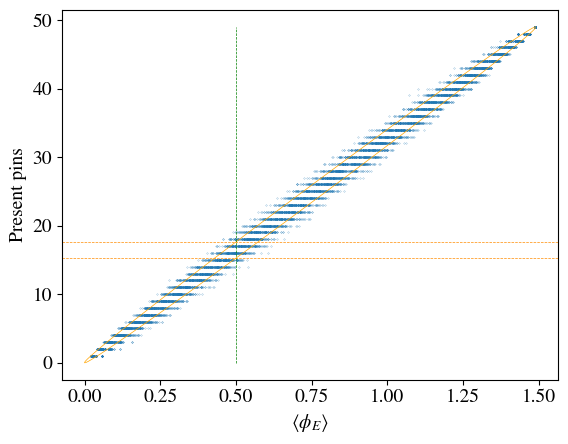

In [21]:
fig=plt.figure()
plt.scatter(x,y,s=0.1,marker='.')
#plt.scatter(yavg/m,yavg,marker='.', color='red')
pts=np.linspace(0,np.max(x),1000)
plt.plot(pts,top_elli_pretrans(pts),color='orange',linewidth=0.5)
plt.plot(pts,bot_elli_pretrans(pts),color='orange',linewidth=0.5)
plt.ylabel('Present pins')
plt.xlabel('$\langle\phi_E\\rangle$') # Double \\ before rangle to avoid py interpreting \r
plt.vlines(x=fluence_test,ymin=0,ymax=np.max(y),color='green',linestyle='--',linewidth=0.5)
plt.axhline(y=bot_elli_pretrans(fluence_test),xmin=0,xmax=np.max(pts),color='darkorange',linestyle='--',linewidth=0.5)
plt.axhline(y=top_elli_pretrans(fluence_test),xmin=0,xmax=np.max(pts),color='darkorange',linestyle='--',linewidth=0.5)
plt.show()

<h3>What if? - Limitations</h3>

Let us plot the data with bigger, slightly transparent, markers to have a sense of the density using the intensity of the colour.

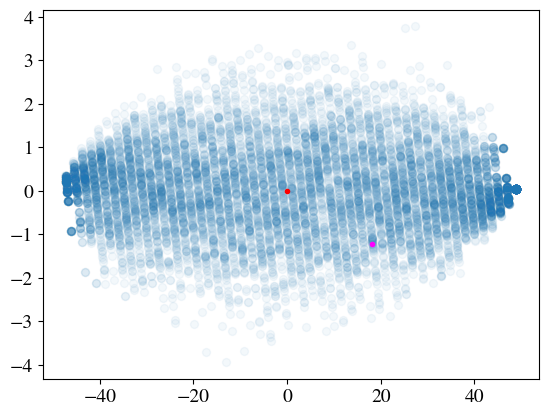

In [22]:
plt.scatter(P[0],P[1],s=130,alpha=0.05,marker='.')
plt.scatter(0,0,marker='.', color='red')
plt.scatter(P[0][3252],P[1][3252],marker='.', color='magenta')
plt.show()

We can see that the distribution of the data is not wholly symmetric with respect to either axis, but rather rotationally symmetric with respect to the middle point (in red). It appears that the outliers have a positive dependence with fluence (and pin number), and that there appears to be *jets* streaming from each extrema with the same positive dependence.

<h2>NN analysis - DNN</h2>

Now we perfom the analysis with a DNN to see whether the results are improved. Let us recall the data.

In [23]:
df.head()

,AssemblyPinslots,SpectraCylinder
0,"[[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1],...","[[1.2698557], [1.3029325], [1.4130867], [1.641..."
1,"[[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1],...","[[1.2698557], [1.3029325], [1.4130867], [1.641..."
2,"[[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1],...","[[1.2698557], [1.3029325], [1.4130867], [1.641..."
3,"[[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1],...","[[1.2698557], [1.3029325], [1.4130867], [1.641..."
4,"[[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1],...","[[1.2698557], [1.3029325], [1.4130867], [1.641..."


And what we did for the statistical study.
    
    Y=np.array(df['AssemblyPinslots'].tolist())
    X=np.array(df['SpectraCylinder'].tolist())
    y=np.array([np.sum(ass) for ass in Y])
    x=np.array([np.sum(spect)/len(spect) for spect in X])
    
We wish to fit `y` with respect to `X`.

In [24]:
# First we normalise y and X
y_norm=y/np.max(y)
X_norm=X/np.max(X)
X_norm=np.reshape(X_norm,np.shape(X_norm)[:-1])
print('Normalization of X:',np.min(X_norm),'to',np.max(X_norm))

Normalization of X: 0.0030954315 to 1.0


Note that if we normalise the logarithm of X the NN won't classify as well.

In [25]:
# We shuffle the dataentries and the truths
shuffle=np.random.permutation(range(len(X_norm)))
X_shf=X_norm[shuffle]
y_shf=y_norm[shuffle] # The network will predict the ammount of present pins
 
    # And separate the training, validation and testing sets
n_train=int(0.8*len(x))
X_train=X_shf[:n_train]
X_val=X_shf[n_train:]
y_train=y_shf[:n_train]
y_val=y_shf[n_train:]

In [26]:
    # Some checks
print(y_norm[0:10])
print(y_train[0:10])
print('All represented in training: ',np.all(np.unique(y_train)==np.unique(y_norm)))
print('All represented in validation: ',np.all(np.unique(y_val)==np.unique(y_norm)))
print('Number of instances in training for each unique y:\n ', [np.sum(y_train==i) for i in np.unique(y_train)])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.26530612 0.2244898  0.57142857 0.32653061 0.18367347 0.73469388
 0.65306122 0.36734694 0.12244898 0.83673469]
All represented in training:  True
All represented in validation:  True
Number of instances in training for each unique y:
  [156, 161, 154, 161, 156, 166, 145, 167, 151, 167, 164, 166, 155, 160, 162, 158, 156, 159, 152, 167, 162, 160, 152, 163, 149, 165, 159, 165, 161, 148, 154, 160, 160, 167, 166, 164, 168, 166, 156, 151, 163, 154, 170, 168, 162, 167, 161, 157, 159]


In [27]:
import tensorflow as tf

from tensorflow.keras import models
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.optimizers import Adam,SGD

2024-06-10 09:22:44.139476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
    # We define our own progress metric - to represent the npins regression accuracy
def npins_accuracy(y_true,y_pred,uncert=0):
        return tf.reduce_mean(tf.cast(tf.abs(y_pred-y_true)<((1+2*uncert)/(2*np.max(y))),'float'))

In [29]:
# Hiperparameters
batch_size=10
epochs = 300
lr=0.001

DNN=models.Sequential([Input(shape=(np.shape(X_train)[1],)),
                     Dense(100,activation='elu'),
                     Dense(30,activation='elu'),                   
                     Dense(1,activation=None)],
                     name='DNN_Adam'+str(epochs)+'_7')

DNN.compile(loss=tf.keras.losses.MeanSquaredError(),
             optimizer=Adam(learning_rate=lr),
             metrics=[npins_accuracy])

DNN.summary()

Model: "DNN_Adam300_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3300      
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 6,361
Trainable params: 6,361
Non-trainable params: 0
_________________________________________________________________


2024-06-10 09:22:46.734460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
fitNN=0

In [31]:
if fitNN:
    historyDNN=DNN.fit(X_train,y_train[:,np.newaxis],batch_size=batch_size,epochs=epochs)
    DNN.save('KerasModels/'+str(DNN.name)+'.keras')
    np.save('./History_Data/'+str(DNN.name)+'_History',
        np.array([historyDNN.history['loss'],historyDNN.history['npins_accuracy']]))
else:
    DNN=models.load_model('KerasModels/'+str(DNN.name)+'.keras', 
                          custom_objects={'npins_accuracy': npins_accuracy})
    historyDNN_up=np.load('./History_Data/'+str(DNN.name)+'_History.npy')

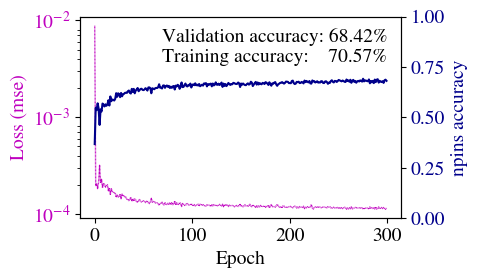

Validation accuracy: 68.42 %
Training accuracy: 70.57 %


In [32]:
    # Let us plot how well the NN is doing.
    
    fig, ax1 = plt.subplots(figsize=(5,3))

    ax1.set_xlabel('Epoch')
    color = 'm'
    ax1.set_yscale('log')
    ax1.set_ylabel('Loss (mse)', color=color)
    ax1.set_yticks([1e-1,1e-2,1e-3,1e-4])
    ax1.set_yticks([2e-1,2e-2,2e-3,2e-4,3e-1,3e-2,3e-3,3e-4,4e-2,4e-3,4e-4,5e-2,5e-3,5e-4,6e-2,6e-3,6e-4,
                   7e-2,7e-3,7e-4,8e-2,8e-3,8e-4],minor=True)
    ax1.tick_params(axis='y', labelcolor=color)
    if fitNN:
        ax1.plot(historyDNN.history['loss'],color=color,dashes=[0.6,0.4],linewidth=1)
    else:
        ax1.plot(historyDNN_up[0],color=color,dashes=[0.6,0.4],linewidth=1)

    ax2=ax1.twinx()

    color = 'darkblue'
    ax2.set_yscale('linear')
    ax2.set_ylim(0,1)
    ax2.set_ylabel('npins accuracy', color=color)
    ax2.set_yticks(np.arange(5)/4)
    ax2.tick_params(axis='y', labelcolor=color)
    if fitNN:
        ax2.plot(historyDNN.history['npins_accuracy'], color=color)
    else:
        ax2.plot(historyDNN_up[1], color=color)
    
    acc=npins_accuracy(y_val[:,np.newaxis],DNN.predict(X_val,verbose=False)).numpy()
    acc_train=npins_accuracy(y_train[:,np.newaxis],DNN.predict(X_train,verbose=False)).numpy()
    plt.text(epochs,0.85,
            'Validation accuracy: %.2f'%(acc*100)+'%%\nTraining accuracy:    %.2f'%(acc_train*100)+'%',
            ha='right',va='center')

    fig.tight_layout()
    plt.savefig('./Graphs/ESS/'+str(DNN.name)+'.pdf')
    plt.show()
    
    
    #Accuracy
    print('Validation accuracy: %.2f'%(acc*100),'%')
    print('Training accuracy: %.2f'%(acc_train*100),'%')

Both accuracies are very similar, so there is no evidence of overfitting.

<h3>Performance checks</h3>

For a fast way to check the accuracy of the fit the ```model.evatuate()``` method computes the loss and the metrics for a set of data entries.

In [33]:
DNN.evaluate(X_val,y_val[:,np.newaxis])

62/62 [==============================] - 0s 733us/step - loss: 1.0723e-04 - npins_accuracy: 0.6850


[0.00010722964361775666, 0.6849798560142517]

Alternatively, we can use the ```npins_accuracy()``` function with variable uncertainty to see how accurate the model if we relax the correct classification condition.

In [34]:
npins_accuracy(y_val[:,np.newaxis],DNN.predict(X_val,verbose=False),uncert=0).numpy()

0.68418366

Notice how in this case with an uncertainty of $\pm$ 1 we arrive at a far better accuracy (sometimes even 1).

<h2>NN analysis - CNN</h2>

Now we perfom the analysis with a CNN to see whether the results are improved. Let us recall the data.

In [35]:
from tensorflow.keras.layers import Flatten, Reshape, Conv2D, MaxPooling2D

In [36]:
batch_size=10
epochs=300
lr=0.0001
nAngles=len(X_train[1])

CNN=models.Sequential([Input(shape=(np.shape(X_train)[1],)),
                     Reshape((nAngles,1,1)),
                     Conv2D(8,kernel_size=(3,1),activation='elu'),
                     MaxPooling2D((2,1)),
                     Flatten(),
                     Dense(50,activation='elu'),
                     Dense(1,activation=None)],
                     name='CNN_Adam'+str(epochs)+'_7',)

CNN.compile(loss='mse',
             optimizer=Adam(learning_rate=lr),
             metrics=[npins_accuracy])

CNN.summary()

Model: "CNN_Adam300_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 32, 1, 1)          0         
                                                                 
 conv2d (Conv2D)             (None, 30, 1, 8)          32        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 1, 8)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 120)               0         
                                                                 
 dense_3 (Dense)             (None, 50)                6050      
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                     

In [37]:
if fitNN:
    historyCNN=CNN.fit(X_train,y_train[:,np.newaxis],batch_size=batch_size,epochs=epochs)
    CNN.save('KerasModels/'+str(CNN.name)+'.keras')
    np.save('./History_Data/'+str(CNN.name)+'_History',
        np.array([historyCNN.history['loss'],historyCNN.history['npins_accuracy']]))
else:
    CNN=models.load_model('KerasModels/'+str(CNN.name)+'.keras', 
                          custom_objects={'npins_accuracy': npins_accuracy})
    historyCNN_up=np.load('./History_Data/'+str(CNN.name)+'_History.npy')

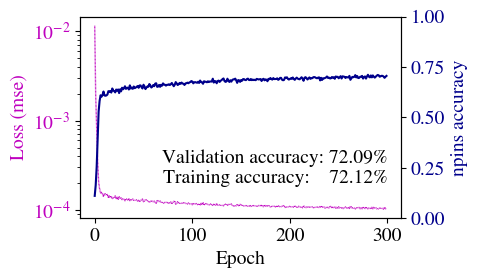

Validation accuracy: 72.09 %
Training accuracy: 72.12 %


In [38]:
    # Let us plot how well the NN is doing.

    fig, ax1 = plt.subplots(figsize=(5,3))

    ax1.set_xlabel('Epoch')
    color = 'm'
    ax1.set_yscale('log')
    ax1.set_ylabel('Loss (mse)', color=color)
    #ax1.set_yticks([1e-1,1e-2,1e-3,1e-4])
    #ax1.set_yticks([2e-1,2e-2,2e-3,2e-4,3e-1,3e-2,3e-3,3e-4,4e-2,4e-3,4e-4,5e-2,5e-3,5e-4,6e-2,6e-3,6e-4,
                   #7e-2,7e-3,7e-4,8e-2,8e-3,8e-4],minor=True)
    ax1.tick_params(axis='y', labelcolor=color)
    if fitNN:
        ax1.plot(historyCNN.history['loss'], color=color, dashes=[0.6,0.4],linewidth=1)
    else:
        ax1.plot(historyCNN_up[0], color=color, dashes=[0.6,0.4],linewidth=1)

    ax2=ax1.twinx()

    color = 'darkblue'
    ax2.set_yscale('linear')
    ax2.set_ylim(0,1)
    ax2.set_ylabel('npins accuracy', color=color)
    ax2.set_yticks(np.arange(5)/4)
    ax2.tick_params(axis='y', labelcolor=color)
    if fitNN:
        ax2.plot(historyCNN.history['npins_accuracy'], color=color)
    else:
        ax2.plot(historyCNN_up[1], color=color)

    acc=npins_accuracy(y_val[:,np.newaxis],CNN.predict(X_val,verbose=False)).numpy()
    acc_train=npins_accuracy(y_train[:,np.newaxis],CNN.predict(X_train,verbose=False)).numpy()
    plt.text(epochs,0.25,
            'Validation accuracy: %.2f'%(acc*100)+'%%\nTraining accuracy:    %.2f'%(acc_train*100)+'%',
            ha='right',va='center')
    
    fig.tight_layout()
    plt.savefig('./Graphs/ESS/'+str(CNN.name)+'.pdf')
    plt.show()
        
        
        #Accuracy
    print('Validation accuracy: %.2f'%(acc*100),'%')
    print('Training accuracy: %.2f'%(acc_train*100),'%')

<h2>Comparison of the two architectures</h2>

Let us plot the evolution of the two architectures with both optimisers for an easier comparison.

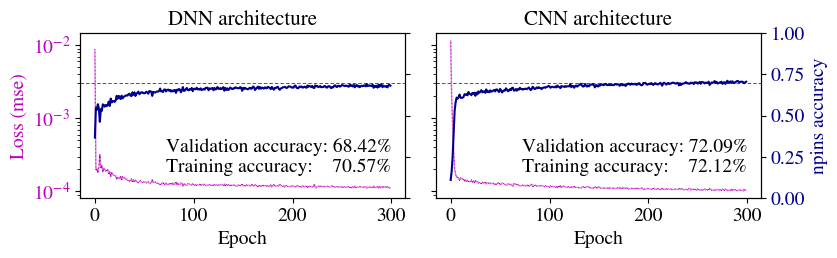

In [39]:
fig, axs = plt.subplots(1,2,sharey=True,figsize=(8.5,2.8))

for ax in axs: ax.set_xlabel('Epoch')

    # -- Plotting the loss
    
axs[0].set_yscale('log')
color = 'm'
axs[0].set_ylabel('Loss (mse)', color=color)
#axs[0].set_yticks([1e-1,1e-2,1e-3,1e-4])
#axs[0].set_yticks([2e-1,2e-2,2e-3,2e-4,3e-1,3e-2,3e-3,3e-4,4e-2,4e-3,4e-4,5e-2,5e-3,5e-4,6e-2,6e-3,6e-4,
                   #7e-2,7e-3,7e-4,8e-2,8e-3,8e-4],minor=True)
axs[0].tick_params(axis='y', labelcolor=color)
    
if fitNN:
    axs[0].plot(historyDNN.history['loss'], color=color, dashes=[0.6,0.4],linewidth=1)
    axs[1].plot(historyCNN.history['loss'], color=color, dashes=[0.6,0.4],linewidth=1)
else:
    axs[0].plot(historyDNN_up[0], color=color, dashes=[0.6,0.4],linewidth=1)
    axs[1].plot(historyCNN_up[0], color=color, dashes=[0.6,0.4],linewidth=1)

    # -- Plotting the accuracy
    
axs2=[ax.twinx() for ax in axs]
axs2[0].sharey(axs2[1])

color = 'darkblue'
axs2[1].set_yscale('linear')
axs2[1].set_ylim(0,1)

axs2[1].set_ylabel('npins accuracy', color=color)
#axs2[1].set_yticks(np.arange(5)/4)
axs2[1].tick_params(axis='y', labelcolor=color)
axs2[0].tick_params(labelright=False)

for ax in axs2:
    ax.axhline(y=0.7,dashes=[5,3],linewidth=0.5,color=color)

if fitNN:
    axs2[0].plot(historyDNN.history['npins_accuracy'], color=color)
    axs2[1].plot(historyCNN.history['npins_accuracy'], color=color)
else:
    axs2[0].plot(historyDNN_up[1], color=color)
    axs2[1].plot(historyCNN_up[1], color=color)

    # -- Additional stuff
axs[0].set_title('DNN architecture',fontsize=15)
axs[1].set_title('CNN architecture',fontsize=15)

acc_val_=np.array([npins_accuracy(y_val[:,np.newaxis],DNN.predict(X_val,verbose=False)).numpy(),
              npins_accuracy(y_val[:,np.newaxis],CNN.predict(X_val,verbose=False)).numpy()])
acc_train_=np.array([npins_accuracy(y_train[:,np.newaxis],DNN.predict(X_train,verbose=False)).numpy(),
                     npins_accuracy(y_train[:,np.newaxis],CNN.predict(X_train,verbose=False)).numpy()])
for i in range(2):
    axs2[i].text(epochs,0.25,
       'Validation accuracy: %.2f'%(acc_val_[i]*100)+'%%\nTraining accuracy:    %.2f'%(acc_train_[i]*100)+'%',
        ha='right',va='center')
    
fig.tight_layout()
plt.savefig('./Graphs/ESS/Comp_'+str(DNN.name)+'_'+str(CNN.name)+'.pdf')
plt.show()
        
        
        #Accuracy
# print('Validation accuracy: %.2f'%(acc*100),'%')
# print('Training accuracy: %.2f'%(acc_train*100),'%')